# LOAN PREDICTION

**Predict Loan Eligibility for Dream Housing Finance company**

Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan. Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 

**Data Collection from Analytics Vidhya**
* The link for the dataset is given below:
    https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/#ProblemStatement

In [1]:
#Importing some necessary libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
os.chdir(r"C:\Users\riama\Desktop\Machine_learning")

In [3]:
loan=pd.read_csv("loan_train.csv")

In [4]:
loan.shape

(614, 13)

In [5]:
loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
#setting the loan id as index and not dropping that bcz later on we need to access the data from here itself 
#that who is eligible for loan or not
loan.set_index('Loan_ID',inplace=True)

In [7]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


**As per the above info there are 7 categorical and 5 numerical**

In [8]:
loan.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

**As we can see that there are missing values hence we will fill that accordingly for categorical will use mode or will replace that either by unknown as per the requirements and for the variable will fill median because mean does is not good if there are outliers in the data hence will fill median accordingly**

#### Univariate Analysis

In [9]:
#creating the function for the numerical variable 
def univar_num(y):
    missing= y.isnull().sum()
    min1=round(y.min(),2)
    max1=round(y.max(),2)
    mean=round(y.mean(),2)
    var=round(y.var(),2)
    std=round(y.std(),2)
    range1=round(max1-min1,2)
    q1= round(y.quantile(.25),2)
    q2=round(y.quantile(.5),2)
    q3=round(y.quantile(.75),2)
    skew=round(y.skew(),2)
    kurt=round(y.kurt(),2)
    myval={"Missing Value":missing,"Minimum value": min1,"Maximum value": max1, "Mean value": mean,"Variance": var,"Standard Deviation": std,"Range": range1,
          "Quantile1":q1,"Quantile2": q2,"Quantile3":q3,"Skewness": skew,"kurtosis":kurt}
    sns.histplot(y)
    plt.show()
    sns.boxplot(data=loan,y=y)
    plt.show()
    return myval

In [10]:
#creating the function for the categorical variables 
def univar(data,y):
    unique_count= data[y].nunique()
    missing= data[y].isnull().sum()
    unique_cat= list(data[y].unique())
    f1=pd.DataFrame(data[y].value_counts())
    f1.rename(columns={y:"Count"},inplace=True)
    f2=pd.DataFrame(data[y].value_counts(normalize=True))
    f2.rename(columns={y:"percentage"},inplace=True)
    f2["percentage"]=round(f2["percentage"]*100,2)  #(f2["percentage"]*100).round(2).astype(str)+"%" (if we want to add percentage
                                                    #then we have to convert it to string then will add %symbol)
    ff=pd.concat([f1,f2],axis=1)
    
    myvalue= {"missing":missing,"unique category": unique_cat,"unique_count":unique_count}
    print(f"value count and %\n",ff)
    sns.countplot(data=data,x=y)
    return myvalue

In [11]:
loan.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [12]:
#finding those variable where column is object based 
loan.dtypes[loan.dtypes=="object"].index

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')

**I am treating the missing values along with the column check**

value count and %
         Count  percentage
Male      489       81.36
Female    112       18.64


{'missing': 13, 'unique category': ['Male', 'Female', nan], 'unique_count': 2}

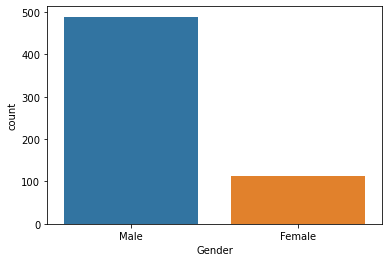

In [13]:
#'Gender', 'Married', 'Dependents', 'Education',
#        'Self_Employed', 'Property_Area', 'Loan_Status'
univar(loan, "Gender")

In [14]:
loan["Gender"].isnull().sum()

13

**As per the above we can see that there are 13 missing value hence I am replacing that with unknown column **

In [15]:
loan["Gender"]=loan["Gender"].replace(np.nan,"unknown")

In [16]:
loan["Gender"].isnull().sum()

0

value count and %
      Count  percentage
Yes    398       65.14
No     213       34.86


{'missing': 3, 'unique category': ['No', 'Yes', nan], 'unique_count': 2}

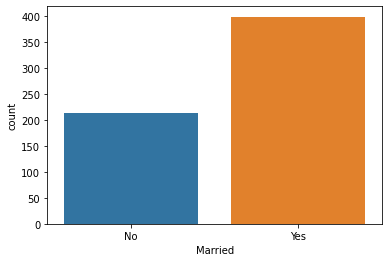

In [17]:
#'Married', 'Dependents', 'Education',
#        'Self_Employed', 'Property_Area', 'Loan_Status'
univar(loan,'Married')

In [18]:
loan[loan["Married"].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


**As per the above I am replacing the missing value with unknown **

In [19]:
loan["Married"]=loan["Married"].replace(np.nan,"unknown")

value count and %
          Count  percentage
Yes        398       64.82
No         213       34.69
unknown      3        0.49


{'missing': 0, 'unique category': ['No', 'Yes', 'unknown'], 'unique_count': 3}

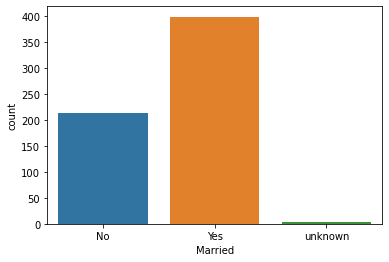

In [20]:
univar(loan,"Married")

value count and %
     Count  percentage
0     345       57.60
1     102       17.03
2     101       16.86
3+     51        8.51


{'missing': 15,
 'unique category': ['0', '1', '2', '3+', nan],
 'unique_count': 4}

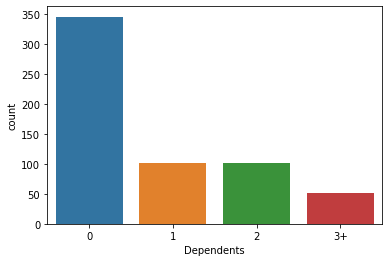

In [21]:
#'Dependents', 'Education',
#        'Self_Employed', 'Property_Area', 'Loan_Status'
univar(loan,"Dependents")

In [22]:
loan[loan["Dependents"].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001350,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
LP001357,Male,unknown,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
LP001426,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
LP001760,Male,unknown,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
LP001945,Female,No,NaN,Graduate,No,5417,0.0,143.0,480.0,0.0,Urban,N
LP001972,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
LP002100,Male,No,NaN,Graduate,No,2833,0.0,71.0,360.0,1.0,Urban,Y
LP002106,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y


In [23]:
loan["Dependents"]=loan["Dependents"].replace(np.nan,"unknown")

**I have replaced the missing value with the unknown and cannot fill mode here bcz if we see the data where there are missing values we can see that there are people who are not yet married hence we do not about them and can't fill mode like this **

value count and %
          Count  percentage
0          345       56.19
1          102       16.61
2          101       16.45
3+          51        8.31
unknown     15        2.44


{'missing': 0,
 'unique category': ['0', '1', '2', '3+', 'unknown'],
 'unique_count': 5}

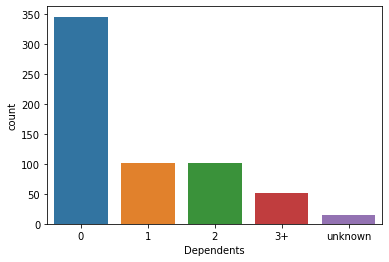

In [24]:
univar(loan,"Dependents")

value count and %
               Count  percentage
Graduate        480       78.18
Not Graduate    134       21.82


{'missing': 0,
 'unique category': ['Graduate', 'Not Graduate'],
 'unique_count': 2}

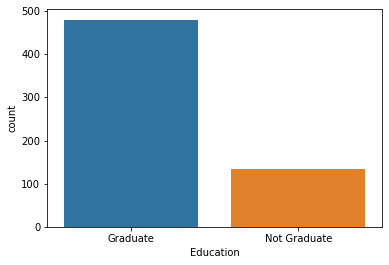

In [25]:
# 'Education',
#        'Self_Employed', 'Property_Area', 'Loan_Status'
univar(loan,"Education")

value count and %
      Count  percentage
No     500       85.91
Yes     82       14.09


{'missing': 32, 'unique category': ['No', 'Yes', nan], 'unique_count': 2}

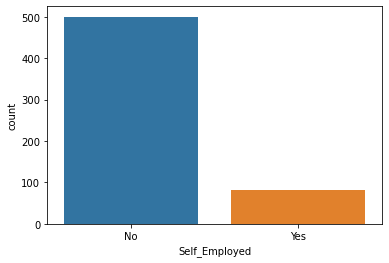

In [26]:
# 'Self_Employed', 'Property_Area', 'Loan_Status'
univar(loan,"Self_Employed")

In [27]:
loan[loan["Self_Employed"].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001027,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
LP001052,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,NaN,Semiurban,N
LP001087,Female,No,2,Graduate,NaN,3750,2083.0,120.0,360.0,1.0,Semiurban,Y
LP001091,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,NaN,Urban,N
LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
LP001387,Female,Yes,0,Graduate,NaN,2929,2333.0,139.0,360.0,1.0,Semiurban,Y
LP001398,Male,No,0,Graduate,NaN,5050,0.0,118.0,360.0,1.0,Semiurban,Y


In [28]:
loan["Self_Employed"]=loan["Self_Employed"].replace(np.nan,"unknown")

value count and %
          Count  percentage
No         500       81.43
Yes         82       13.36
unknown     32        5.21


{'missing': 0, 'unique category': ['No', 'Yes', 'unknown'], 'unique_count': 3}

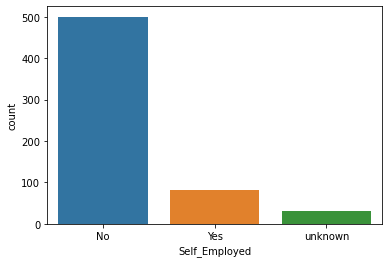

In [29]:
univar(loan,"Self_Employed")

value count and %
            Count  percentage
Semiurban    233       37.95
Urban        202       32.90
Rural        179       29.15


{'missing': 0,
 'unique category': ['Urban', 'Rural', 'Semiurban'],
 'unique_count': 3}

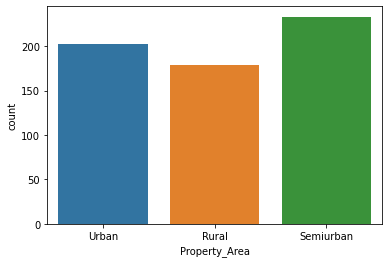

In [30]:
#'Property_Area', 'Loan_Status'
univar(loan,"Property_Area")

value count and %
    Count  percentage
Y    422       68.73
N    192       31.27


{'missing': 0, 'unique category': ['Y', 'N'], 'unique_count': 2}

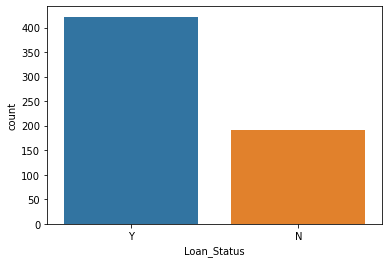

In [31]:
univar(loan,'Loan_Status')

###### I am replacing it in numerical variable 

In [32]:
loan["Loan_Status"]=loan["Loan_Status"].map({"Y":1,"N":0})

value count and %
    Count  percentage
1    422       68.73
0    192       31.27


{'missing': 0, 'unique category': [1, 0], 'unique_count': 2}

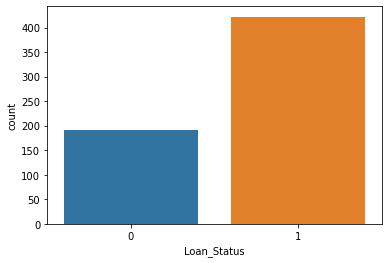

In [33]:
univar(loan,"Loan_Status")

In [35]:
# Checking the variable where column are numerical 

In [34]:
loan.dtypes[loan.dtypes!="object"].index

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

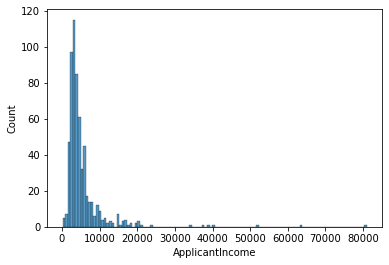

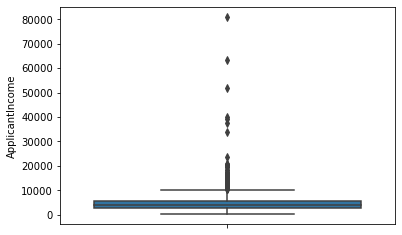

{'Missing Value': 0,
 'Minimum value': 150,
 'Maximum value': 81000,
 'Mean value': 5403.46,
 'Variance': 37320390.17,
 'Standard Deviation': 6109.04,
 'Range': 80850,
 'Quantile1': 2877.5,
 'Quantile2': 3812.5,
 'Quantile3': 5795.0,
 'Skewness': 6.54,
 'kurtosis': 60.54}

In [36]:
# 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
#        'Loan_Amount_Term', 'Credit_History', 'Loan_Status'
univar_num(loan["ApplicantIncome"])

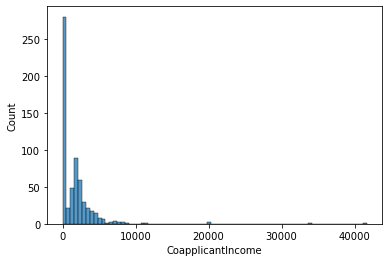

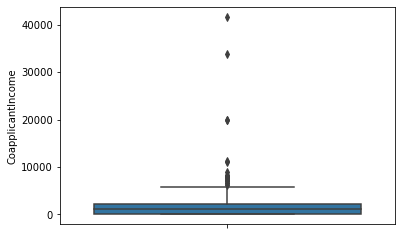

{'Missing Value': 0,
 'Minimum value': 0.0,
 'Maximum value': 41667.0,
 'Mean value': 1621.25,
 'Variance': 8562929.52,
 'Standard Deviation': 2926.25,
 'Range': 41667.0,
 'Quantile1': 0.0,
 'Quantile2': 1188.5,
 'Quantile3': 2297.25,
 'Skewness': 7.49,
 'kurtosis': 84.96}

In [37]:
#'CoapplicantIncome', 'LoanAmount',
#        'Loan_Amount_Term', 'Credit_History', 'Loan_Status'
univar_num(loan["CoapplicantIncome"])

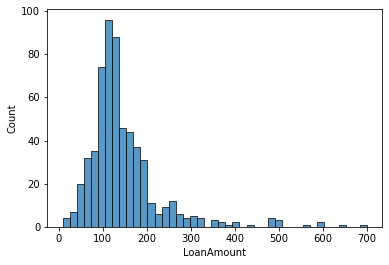

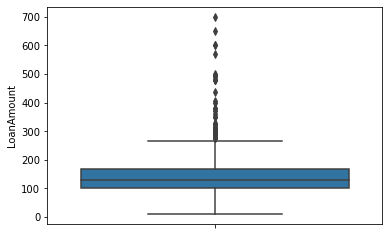

{'Missing Value': 22,
 'Minimum value': 9.0,
 'Maximum value': 700.0,
 'Mean value': 146.41,
 'Variance': 7325.19,
 'Standard Deviation': 85.59,
 'Range': 691.0,
 'Quantile1': 100.0,
 'Quantile2': 128.0,
 'Quantile3': 168.0,
 'Skewness': 2.68,
 'kurtosis': 10.4}

In [38]:
#'LoanAmount',
#        'Loan_Amount_Term', 'Credit_History', 'Loan_Status'
univar_num(loan["LoanAmount"])

**As from the above info I can check that there are missing variable in LoanAmount column hence filling median for that **

In [39]:
loan[loan["LoanAmount"].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
LP001106,Male,Yes,0,Graduate,No,2275,2067.0,NaN,360.0,1.0,Urban,1
LP001213,Male,Yes,1,Graduate,No,4945,0.0,NaN,360.0,0.0,Rural,0
LP001266,Male,Yes,1,Graduate,Yes,2395,0.0,NaN,360.0,1.0,Semiurban,1
LP001326,Male,No,0,Graduate,unknown,6782,0.0,NaN,360.0,NaN,Urban,0
LP001350,Male,Yes,unknown,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,1
LP001356,Male,Yes,0,Graduate,No,4652,3583.0,NaN,360.0,1.0,Semiurban,1
LP001392,Female,No,1,Graduate,Yes,7451,0.0,NaN,360.0,1.0,Semiurban,1
LP001449,Male,No,0,Graduate,No,3865,1640.0,NaN,360.0,1.0,Rural,1


In [40]:
loan["LoanAmount"].median()

128.0

In [41]:
loan["LoanAmount"].fillna(loan["LoanAmount"].median(),inplace=True)

In [42]:
loan["LoanAmount"].isnull().sum()

0

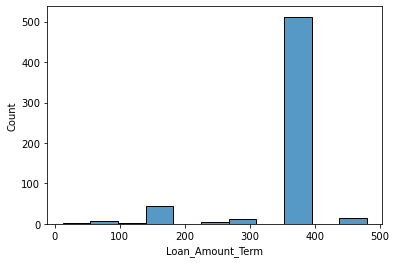

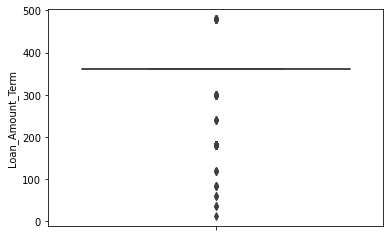

{'Missing Value': 14,
 'Minimum value': 12.0,
 'Maximum value': 480.0,
 'Mean value': 342.0,
 'Variance': 4240.67,
 'Standard Deviation': 65.12,
 'Range': 468.0,
 'Quantile1': 360.0,
 'Quantile2': 360.0,
 'Quantile3': 360.0,
 'Skewness': -2.36,
 'kurtosis': 6.67}

In [43]:
# 'Loan_Amount_Term', 'Credit_History', 'Loan_Status'
univar_num(loan["Loan_Amount_Term"])

There are missing value hence filling median value accordingly 

In [44]:
loan[loan["Loan_Amount_Term"].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001041,Male,Yes,0,Graduate,unknown,2600,3500.0,115.0,NaN,1.0,Urban,1
LP001109,Male,Yes,0,Graduate,No,1828,1330.0,100.0,NaN,0.0,Urban,0
LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,1
LP001137,Female,No,0,Graduate,No,3410,0.0,88.0,NaN,1.0,Urban,1
LP001250,Male,Yes,3+,Not Graduate,No,4755,0.0,95.0,NaN,0.0,Semiurban,0
LP001391,Male,Yes,0,Not Graduate,No,3572,4114.0,152.0,NaN,0.0,Rural,0
LP001574,Male,Yes,0,Graduate,No,3707,3166.0,182.0,NaN,1.0,Rural,1
LP001669,Female,No,0,Not Graduate,No,1907,2365.0,120.0,NaN,1.0,Urban,1
LP001749,Male,Yes,0,Graduate,No,7578,1010.0,175.0,NaN,1.0,Semiurban,1


In [45]:
loan["Loan_Amount_Term"].fillna(loan["Loan_Amount_Term"].median(),inplace=True)

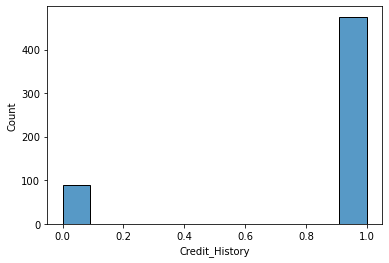

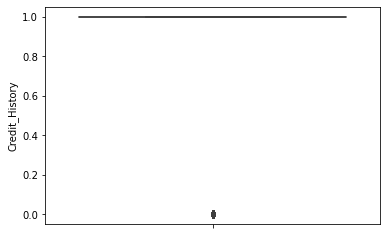

{'Missing Value': 50,
 'Minimum value': 0.0,
 'Maximum value': 1.0,
 'Mean value': 0.84,
 'Variance': 0.13,
 'Standard Deviation': 0.36,
 'Range': 1.0,
 'Quantile1': 1.0,
 'Quantile2': 1.0,
 'Quantile3': 1.0,
 'Skewness': -1.88,
 'kurtosis': 1.55}

In [46]:
#'Credit_History', 'Loan_Status'
univar_num(loan["Credit_History"])

value count and %
      Count  percentage
1.0    475       84.22
0.0     89       15.78


{'missing': 50, 'unique category': [1.0, 0.0, nan], 'unique_count': 2}

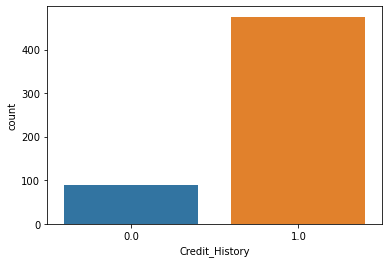

In [47]:
univar(loan,"Credit_History")

In [48]:
loan[loan["Credit_History"].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001034,Male,No,1,Not Graduate,No,3596,0.0,100.0,240.0,NaN,Urban,1
LP001052,Male,Yes,1,Graduate,unknown,3717,2925.0,151.0,360.0,NaN,Semiurban,0
LP001091,Male,Yes,1,Graduate,unknown,4166,3369.0,201.0,360.0,NaN,Urban,0
LP001123,Male,Yes,0,Graduate,No,2400,0.0,75.0,360.0,NaN,Urban,1
LP001264,Male,Yes,3+,Not Graduate,Yes,3333,2166.0,130.0,360.0,NaN,Semiurban,1
LP001273,Male,Yes,0,Graduate,No,6000,2250.0,265.0,360.0,NaN,Semiurban,0
LP001280,Male,Yes,2,Not Graduate,No,3333,2000.0,99.0,360.0,NaN,Semiurban,1
LP001326,Male,No,0,Graduate,unknown,6782,0.0,128.0,360.0,NaN,Urban,0
LP001405,Male,Yes,1,Graduate,No,2214,1398.0,85.0,360.0,NaN,Urban,1


In [49]:
loan["Credit_History"].fillna(loan["Credit_History"].median(),inplace=True)

In [50]:
loan.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

**All missing value has been removed**

##### Bivariate Analysis

Loan_Status         0         1
Gender                         
Female       0.330357  0.669643
Male         0.306748  0.693252
unknown      0.384615  0.615385
AxesSubplot(0.125,0.125;0.775x0.755)


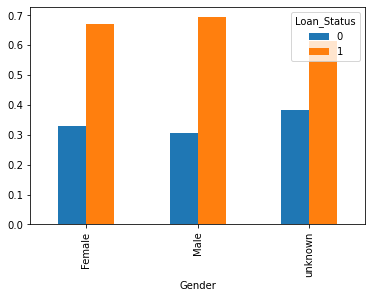

In [51]:

#Cat-Cat
# 'Gender', 'Married', 'Dependents', 'Education',
#        'Self_Employed', 'Property_Area'
print(pd.crosstab(loan["Gender"],loan["Loan_Status"],normalize="index"))
print(pd.crosstab(loan["Gender"],loan["Loan_Status"],normalize="index").plot(kind="bar"))

In [52]:
pd.crosstab(loan["Married"],loan["Loan_Status"],normalize="index")

Loan_Status,0,1
Married,,
No,0.370892,0.629108
Yes,0.283920,0.716080
unknown,0.000000,1.000000


As per the above we can say that who are married they are getting loan 

In [53]:
pd.crosstab(loan["Dependents"],loan["Loan_Status"],normalize="index")

Loan_Status,0,1
Dependents,,
0,0.310145,0.689855
1,0.352941,0.647059
2,0.247525,0.752475
3+,0.352941,0.647059
unknown,0.400000,0.600000


As per the above we can say that who have 2 dependents they are getting approval for the loan

In [54]:
pd.crosstab(loan["Education"],loan["Loan_Status"],normalize="columns")

Loan_Status,0,1
Education,,
Graduate,0.729167,0.805687
Not Graduate,0.270833,0.194313


from this we can say that those are graduate getting approval for the loan 

In [55]:
pd.crosstab(loan["Self_Employed"],loan["Loan_Status"],normalize="columns")

Loan_Status,0,1
Self_Employed,,
No,0.817708,0.812796
Yes,0.135417,0.132701
unknown,0.046875,0.054502


In [56]:
pd.crosstab(loan["Property_Area"],loan["Loan_Status"],normalize="all")

Loan_Status,0,1
Property_Area,,
Rural,0.112378,0.179153
Semiurban,0.087948,0.291531
Urban,0.112378,0.216612


In [57]:
#Cat-Num
loan.dtypes[loan.dtypes!="object"].index

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

            ApplicantIncome            
                       mean  min    max
Loan_Status                            
0               5446.078125  150  81000
1               5384.068720  210  63337
AxesSubplot(0.125,0.125;0.775x0.755)


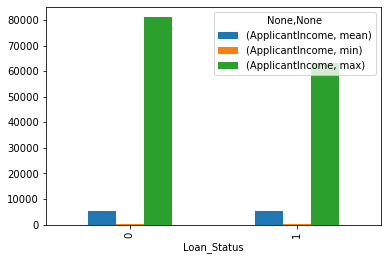

In [58]:
# ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
#        'Loan_Amount_Term', 'Credit_History'
print(loan.groupby(["Loan_Status"]).agg({"ApplicantIncome":["mean","min","max"]}))
print(loan.groupby(["Loan_Status"]).agg({"ApplicantIncome":["mean","min","max"]}).plot(kind="bar"))

            CoapplicantIncome              
                         mean  min      max
Loan_Status                                
0                 1877.807292  0.0  41667.0
1                 1504.516398  0.0  20000.0
AxesSubplot(0.125,0.125;0.775x0.755)


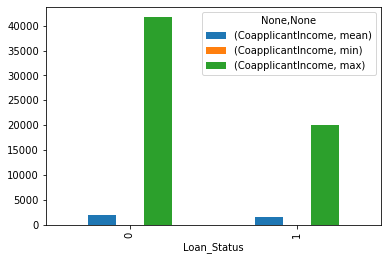

In [59]:
print(loan.groupby(["Loan_Status"]).agg({"CoapplicantIncome":["mean","min","max"]}))
print(loan.groupby(["Loan_Status"]).agg({"CoapplicantIncome":["mean","min","max"]}).plot(kind="bar"))

             LoanAmount             
                   mean   min    max
Loan_Status                         
0            149.890625   9.0  570.0
1            143.869668  17.0  700.0
AxesSubplot(0.125,0.125;0.775x0.755)


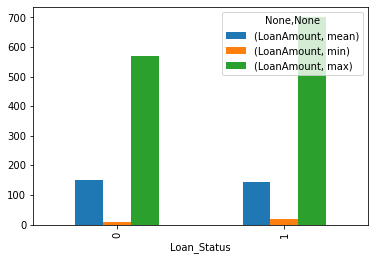

In [60]:
print(loan.groupby(["Loan_Status"]).agg({"LoanAmount":["mean","min","max"]}))
print(loan.groupby(["Loan_Status"]).agg({"LoanAmount":["mean","min","max"]}).plot(kind="bar"))

            Loan_Amount_Term             
                        mean   min    max
Loan_Status                              
0                  344.56250  36.0  480.0
1                  341.43128  12.0  480.0
AxesSubplot(0.125,0.125;0.775x0.755)


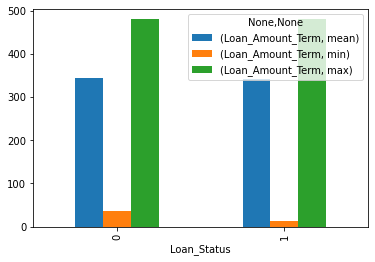

In [61]:
print(loan.groupby(["Loan_Status"]).agg({"Loan_Amount_Term":["mean","min","max"]}))
print(loan.groupby(["Loan_Status"]).agg({"Loan_Amount_Term":["mean","min","max"]}).plot(kind="bar"))

            Credit_History          
                      mean  min  max
Loan_Status                         
0                 0.572917  0.0  1.0
1                 0.983412  0.0  1.0
AxesSubplot(0.125,0.125;0.775x0.755)


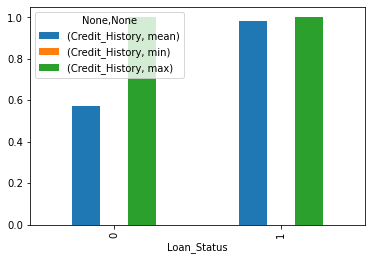

In [62]:
print(loan.groupby(["Loan_Status"]).agg({"Credit_History":["mean","min","max"]}))
print(loan.groupby(["Loan_Status"]).agg({"Credit_History":["mean","min","max"]}).plot(kind="bar"))

##### Outliers

In [63]:
loan.describe(percentiles=[.01,.02,.03,.04,.05,.25,.5,.75,.9,.95,.96,.97,.98,.99]).T

,count,mean,std,min,1%,2%,3%,4%,5%,25%,50%,75%,90%,95%,96%,97%,98%,99%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,1025.00,1554.12,1800.00,1829.04,1897.55,2877.50,3812.5,5795.00,9459.9,14583.0,15364.32,16682.25,19666.04,32540.41,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1188.5,2297.25,3782.2,4997.4,5397.04,5682.67,7198.56,8895.89,41667.0
LoanAmount,614.0,145.752443,84.107233,9.0,30.65,44.00,48.78,54.52,57.30,100.25,128.0,164.75,229.4,293.4,313.44,356.10,427.94,495.87,700.0
Loan_Amount_Term,614.0,342.410423,64.428629,12.0,84.00,180.00,180.00,180.00,180.00,360.00,360.0,360.00,360.0,360.0,360.00,360.00,480.00,480.00,480.0
Credit_History,614.0,0.855049,0.352339,0.0,0.00,0.00,0.00,0.00,0.00,1.00,1.0,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.0
Loan_Status,614.0,0.687296,0.463973,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.0,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.0


as checked there are outliers hence treating them with the Turkey method

In [64]:
var="ApplicantIncome"
q1=loan[var].quantile(.25)
q2=loan[var].quantile(.75)
IQR=q2-q1
lower=q1-1.5*(IQR)
upper=q2+1.5*(IQR)
loan[var]=np.where(loan[var]>=upper,upper,loan[var])
loan[var]=np.where(loan[var]<=lower,lower,loan[var])

<AxesSubplot:ylabel='ApplicantIncome'>

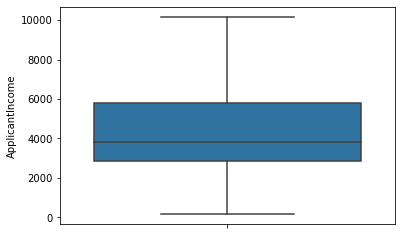

In [65]:
sns.boxplot(data=loan,y="ApplicantIncome")

<AxesSubplot:ylabel='CoapplicantIncome'>

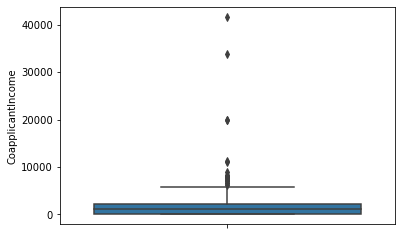

In [66]:
sns.boxplot(data=loan,y="CoapplicantIncome")

In [67]:
var="CoapplicantIncome"
q1=loan[var].quantile(.25)
q2=loan[var].quantile(.75)
IQR=q2-q1
lower=q1-1.5*(IQR)
upper=q2+1.5*(IQR)
loan[var]=np.where(loan[var]>=upper,upper,loan[var])
loan[var]=np.where(loan[var]<=lower,lower,loan[var])

<AxesSubplot:ylabel='CoapplicantIncome'>

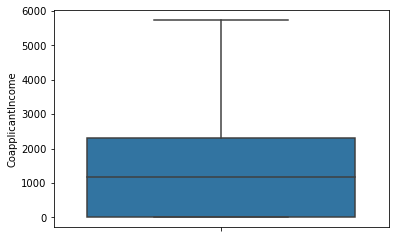

In [68]:
sns.boxplot(data=loan,y="CoapplicantIncome")

In [69]:
var="LoanAmount"
q1=loan[var].quantile(.25)
q2=loan[var].quantile(.75)
IQR=q2-q1
lower=q1-1.5*(IQR)
upper=q2+1.5*(IQR)
loan[var]=np.where(loan[var]>=upper,upper,loan[var])
loan[var]=np.where(loan[var]<=lower,lower,loan[var])

<AxesSubplot:ylabel='LoanAmount'>

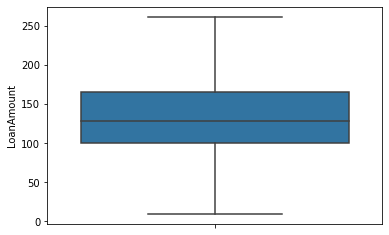

In [70]:
sns.boxplot(data=loan,y="LoanAmount")

<AxesSubplot:ylabel='Loan_Amount_Term'>

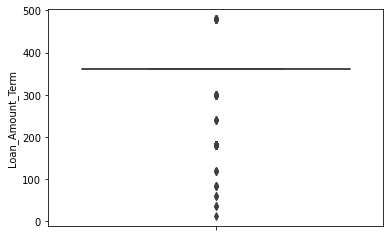

In [71]:
sns.boxplot(data=loan,y="Loan_Amount_Term")

In [72]:
var="Loan_Amount_Term"
q1=loan[var].quantile(.25)
q2=loan[var].quantile(.75)
IQR=q2-q1
lower=q1-1.5*(IQR)
upper=q2+1.5*(IQR)
loan[var]=np.where(loan[var]>=upper,upper,loan[var])
loan[var]=np.where(loan[var]<=lower,lower,loan[var])

##### Dummy Creation

In [73]:
loan_dum=pd.get_dummies(data=loan,drop_first=True)

In [74]:
loan_dum.drop(columns=["Loan_Amount_Term"],inplace=True)

#### Multicollinearity

<AxesSubplot:>

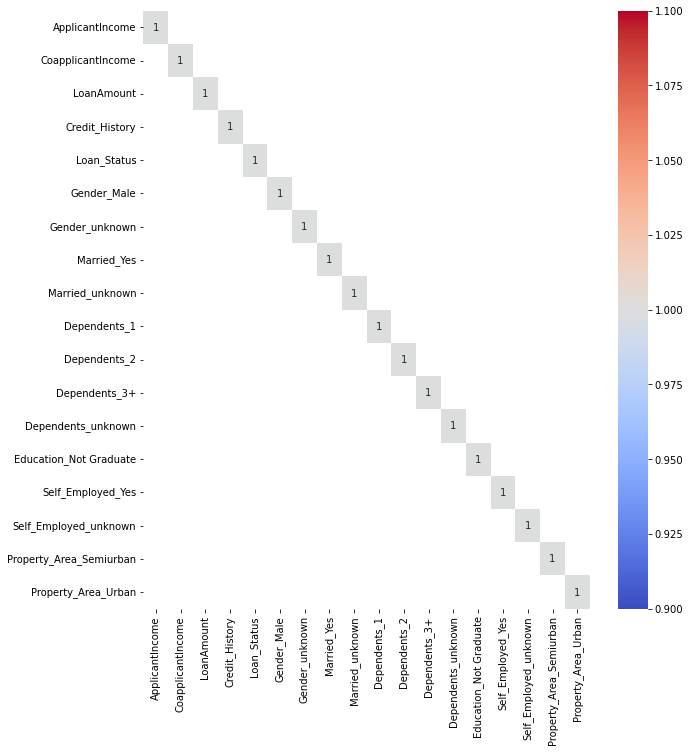

In [75]:
cr=loan_dum.corr()
cr1=cr[abs(cr)>0.7]
plt.figure(figsize=[10,11])
sns.heatmap(cr1,annot=True,cmap="coolwarm")

##### Model Development

In [76]:
y=loan_dum["Loan_Status"]
x=loan_dum.drop(columns=["Loan_Status"])

In [77]:
# from sklearn import metrics
# from sklearn.model_selection import train_test_split,GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [78]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=0)

In [79]:
#Standardizing 
mn=MinMaxScaler()
mn_fit=mn.fit(x_train)
x_train_mn=mn_fit.transform(x_train)
x_test_mn=mn_fit.transform(x_test)

x_train_mn=pd.DataFrame(x_train_mn,columns=x_train.columns)
x_test_mn=pd.DataFrame(x_test_mn,columns=x_test.columns)

In [80]:
logR=LogisticRegression(max_iter=1000)
logR.fit(x_train_mn,y_train)

LogisticRegression(max_iter=1000)

In [81]:
print('Train Score : ', logR.score(x_train_mn,y_train))
print('Test Score : ', logR.score(x_test_mn,y_test))

Train Score :  0.8044806517311609
Test Score :  0.8292682926829268


In [82]:
#predicting
pred_train=logR.predict(x_train_mn)
pred_test=logR.predict(x_test_mn)

In [83]:
def classification(act,pred,probs):
    ac1=metrics.accuracy_score(act,pred)
    rc1=metrics.recall_score(act,pred)
    pc1=metrics.precision_score(act,pred)
    f1=metrics.f1_score(act,pred)
    roc1=metrics.roc_auc_score(act,pred)
    result={"Accuracy":ac1,"Recall":rc1,"Precission":pc1,"F1score": f1, "AUC": roc1}
    
    fpr,tpr,threshold=metrics.roc_curve(act,probs)
    plt.plot([0,1],[0,1],"k--")  #0,1 are the edges starting from 0 to 1 and k-- is for the line which is coming in graph and 
                                 #k is for black color
    plt.plot(fpr,tpr)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()
    return result

In [84]:
prob_train_1=logR.predict_proba(x_train_mn)[:,1]
prob_test_1=logR.predict_proba(x_test_mn)[:,1]

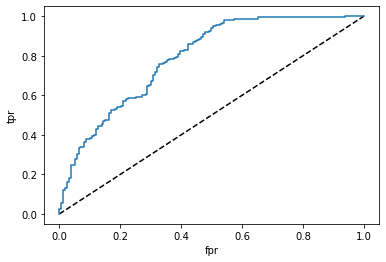

{'Accuracy': 0.8044806517311609,
 'Recall': 0.9849397590361446,
 'Precission': 0.7822966507177034,
 'F1score': 0.872,
 'AUC': 0.7063063575054938}

In [85]:
classification(y_train,pred_train,prob_train_1)

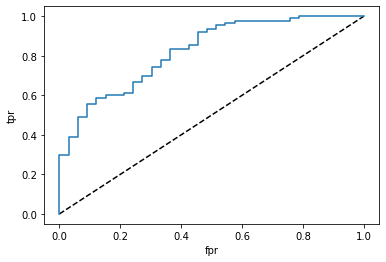

{'Accuracy': 0.8292682926829268,
 'Recall': 0.9777777777777777,
 'Precission': 0.822429906542056,
 'F1score': 0.8934010152284264,
 'AUC': 0.7010101010101011}

In [86]:
classification(y_test,pred_test,prob_test_1)

**As per the above info we can see that recall is 98% for train and 97% for test 
* Accuracy for the train is 80%
* Accuracy for the test is 82%**

##### Decision Tree

In [87]:
dt=DecisionTreeClassifier()
dt.fit(x_train_mn,y_train)

DecisionTreeClassifier()

In [88]:
print('Train Accuracy :',round(dt.score(x_train_mn,y_train),3))
print('Test Accuracy :',round(dt.score(x_test_mn,y_test),3))

Train Accuracy : 1.0
Test Accuracy : 0.699


In [89]:
#finding the best parameters 
params={
    'criterion': ['gini','entropy'],
    'max_depth': [5,7,9,10,11],
    'min_samples_split': [10,15,20,50,100,200,250],
    'min_samples_leaf': [5,10,15,20,50,80,100]}

dtg=DecisionTreeClassifier()
gd_search=GridSearchCV(estimator=dtg,param_grid=params,cv=10,n_jobs=-1,verbose=2)
gd_search.fit(x_train_mn,y_train)

Fitting 10 folds for each of 490 candidates, totalling 4900 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9, 10, 11],
                         'min_samples_leaf': [5, 10, 15, 20, 50, 80, 100],
                         'min_samples_split': [10, 15, 20, 50, 100, 200, 250]},
             verbose=2)

In [90]:
gd_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=200)

In [91]:
gd_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 15,
 'min_samples_split': 200}

In [92]:
dt1=DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_leaf=15,min_samples_split=200)
dt1.fit(x_train_mn,y_train)

print("Train Accuracy:" ,dt1.score(x_train_mn,y_train))
print("Test Accuracy:" ,dt1.score(x_test_mn,y_test))

Train Accuracy: 0.8044806517311609
Test Accuracy: 0.8292682926829268


In [93]:
def classification(act,pred,probs):
    ac1=metrics.accuracy_score(act,pred)
    rc1=metrics.recall_score(act,pred)
    pc1=metrics.precision_score(act,pred)
    f1=metrics.f1_score(act,pred)
    roc1=metrics.roc_auc_score(act,pred)
    result={"Accuracy":ac1,"Recall":rc1,"Precission":pc1,"F1score": f1, "AUC": roc1}
    
    fpr,tpr,threshold=metrics.roc_curve(act,probs)
    plt.plot([0,1],[0,1],"k--")  #0,1 are the edges starting from 0 to 1 and k-- is for the line which is coming in graph and 
                                 #k is for black color
    plt.plot(fpr,tpr)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()
    return result

In [94]:
pred_train_dt=dt1.predict(x_train_mn)
pred_test_dt=dt1.predict(x_test_mn)

In [95]:
prob_train_dt=dt1.predict_proba(x_train_mn)[:,1]
prob_test_dt=dt1.predict_proba(x_test_mn)[:,1]

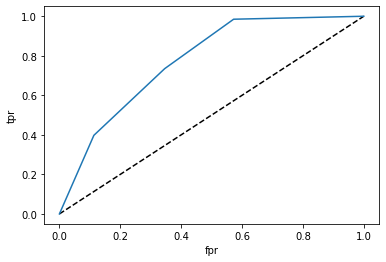

{'Accuracy': 0.8044806517311609,
 'Recall': 0.9849397590361446,
 'Precission': 0.7822966507177034,
 'F1score': 0.872,
 'AUC': 0.7063063575054938}

In [96]:
classification(y_train,pred_train_dt,prob_train_dt)

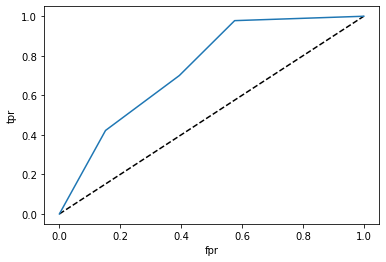

{'Accuracy': 0.8292682926829268,
 'Recall': 0.9777777777777777,
 'Precission': 0.822429906542056,
 'F1score': 0.8934010152284264,
 'AUC': 0.7010101010101011}

In [97]:
classification(y_test,pred_test_dt,prob_test_dt)

** As per the above we can say that recall is 98% for train and 97% for test
- Accuracy is 80% for train
- Accuracy is 82% for test

##### Random Forest

In [98]:
rf=RandomForestClassifier()
rf.fit(x_train_mn,y_train)

RandomForestClassifier()

In [99]:
print("Train Accuracy: ", rf.score(x_train_mn,y_train))
print("Test Accuracy: ", rf.score(x_test_mn,y_test))

Train Accuracy:  1.0
Test Accuracy:  0.8130081300813008


In [100]:
params={"n_estimators":[100,150,200],
       "criterion":["gini","entropy"],
       "max_depth":[9,11,13],
       "min_samples_split":[50,100],
       "min_samples_leaf":[5,10,15],
       "max_features":["sqrt","log2"],
       "bootstrap":[True]
       }
rf1=RandomForestClassifier()
gs_rf=GridSearchCV(estimator=rf1,param_grid=params,cv=10,n_jobs=-1,verbose=1)
gs_rf.fit(x_train_mn,y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [9, 11, 13],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [50, 100],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [101]:
gs_rf.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=50)

In [102]:
gs_rf.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 50,
 'n_estimators': 100}

In [106]:
rf2=RandomForestClassifier(max_depth=9,max_features="sqrt",min_samples_leaf=5,min_samples_split=50,n_estimators=200)

In [107]:
rf2.fit(x_train_mn,y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=50,
                       n_estimators=200)

In [108]:
print("Train Accuracy: ", rf2.score(x_train_mn,y_train))
print("Test Accuracy: ", rf2.score(x_test_mn,y_test))

Train Accuracy:  0.8044806517311609
Test Accuracy:  0.8292682926829268


In [109]:
def classification(act,pred,probs):
    ac1=metrics.accuracy_score(act,pred)
    rc1=metrics.recall_score(act,pred)
    pc1=metrics.precision_score(act,pred)
    f1=metrics.f1_score(act,pred)
    roc1=metrics.roc_auc_score(act,pred)
    result={"Accuracy":ac1,"Recall":rc1,"Precission":pc1,"F1score": f1, "AUC": roc1}
    
    fpr,tpr,threshold=metrics.roc_curve(act,probs)
    plt.plot([0,1],[0,1],"k--")  #0,1 are the edges starting from 0 to 1 and k-- is for the line which is coming in graph and 
                                 #k is for black color
    plt.plot(fpr,tpr)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()
    return result

In [110]:
pred_train_rf=rf2.predict(x_train_mn)
pred_test_rf=rf2.predict(x_test_mn)

In [111]:
prob_train_rf=rf2.predict_proba(x_train_mn)[:,1]
prob_test_rf=rf2.predict_proba(x_test_mn)[:,1]

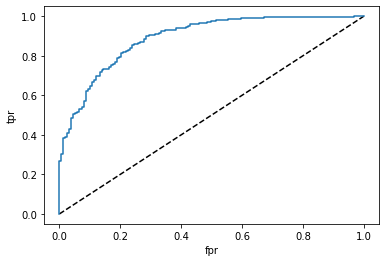

{'Accuracy': 0.8044806517311609,
 'Recall': 0.9849397590361446,
 'Precission': 0.7822966507177034,
 'F1score': 0.872,
 'AUC': 0.7063063575054938}

In [112]:
classification(y_train,pred_train_rf,prob_train_rf)#

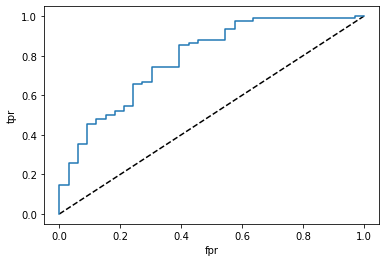

{'Accuracy': 0.8292682926829268,
 'Recall': 0.9777777777777777,
 'Precission': 0.822429906542056,
 'F1score': 0.8934010152284264,
 'AUC': 0.7010101010101011}

In [113]:
classification(y_test,pred_test_rf,prob_test_rf)

##### SVM(Support Vector Machines)

In [116]:
from sklearn import svm
svm1=svm.LinearSVC()
svm1.fit(x_train_mn, y_train)

LinearSVC()

In [117]:
print('Train Accuracy :', svm1.score(x_train_mn, y_train))
print('Test Accuracy :', svm1.score(x_test_mn, y_test))

Train Accuracy : 0.8044806517311609
Test Accuracy : 0.8292682926829268


In [118]:
svm2=svm.SVC()     
svm2.fit(x_train_mn,y_train)

SVC()

In [119]:
print('Train Accuracy :', svm2.score(x_train_mn, y_train))
print('Test Accuracy :', svm2.score(x_test_mn, y_test))

Train Accuracy : 0.8044806517311609
Test Accuracy : 0.8292682926829268


In [120]:
##Hyperparameter
params={'kernel':['linear','poly','rbf'],
         'degree': [2,3,4],
         'gamma': [0.1, 1, .001],
         'C': [0.001,0.01,0.1,1,10,100,200]
        }
sv=svm.SVC()
svm_rs=GridSearchCV(sv, params, cv=10, n_jobs=-1, verbose=True)
svm_rs.fit(x_train_mn,y_train)

Fitting 10 folds for each of 189 candidates, totalling 1890 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 200],
                         'degree': [2, 3, 4], 'gamma': [0.1, 1, 0.001],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=True)

In [121]:
svm_rs.best_params_

{'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}

In [122]:
svm_rs.best_estimator_

SVC(C=0.01, degree=2, gamma=1, kernel='poly')

In [127]:
sv1=svm.SVC(C=0.01, degree=2, gamma=1, kernel='poly',probability=True)                    
sv1.fit(x_train_mn, y_train)

print('Train Accuracy : ', sv1.score(x_train_mn,y_train))
print('Test Accuracy : ', sv1.score(x_test_mn,y_test))

Train Accuracy :  0.8044806517311609
Test Accuracy :  0.8292682926829268


In [128]:
pred_train_svm=sv1.predict(x_train_mn)
pred_test_svm=sv1.predict(x_test_mn)

In [129]:
prob_train_svm=sv1.predict_proba(x_train_mn)[:,1]
prob_test_svm=sv1.predict_proba(x_test_mn)[:,1]

In [130]:
def classification(act,pred,probs):
    ac1=metrics.accuracy_score(act,pred)
    rc1=metrics.recall_score(act,pred)
    pc1=metrics.precision_score(act,pred)
    f1=metrics.f1_score(act,pred)
    roc1=metrics.roc_auc_score(act,pred)
    result={"Accuracy":ac1,"Recall":rc1,"Precission":pc1,"F1score": f1, "AUC": roc1}
    
    fpr,tpr,threshold=metrics.roc_curve(act,probs)
    plt.plot([0,1],[0,1],"k--")  #0,1 are the edges starting from 0 to 1 and k-- is for the line which is coming in graph and 
                                 #k is for black color
    plt.plot(fpr,tpr)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()
    return result

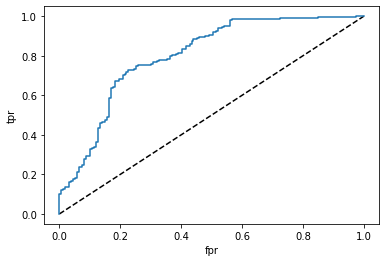

{'Accuracy': 0.8044806517311609,
 'Recall': 0.9849397590361446,
 'Precission': 0.7822966507177034,
 'F1score': 0.872,
 'AUC': 0.7063063575054938}

In [131]:
classification(y_train,pred_train_svm,prob_train_svm)

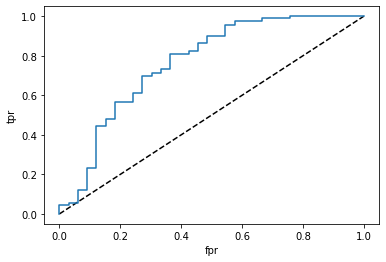

{'Accuracy': 0.8292682926829268,
 'Recall': 0.9777777777777777,
 'Precission': 0.822429906542056,
 'F1score': 0.8934010152284264,
 'AUC': 0.7010101010101011}

In [132]:
classification(y_test,pred_test_svm,prob_test_svm)

* **The Accuracy of Logistic Regression is 83% for test and for train it's 80%**
    * Precision Value for those whose loan is `not approved`: Train is 78% and Test is 88%
    * Recall Value for those whose loan is `not approved`:Train is 98% and Test is 42%

   
     * Precision Value for those whose loan is `approved`: Train is 78% and Test is 82%
     * Recall Value for those whose loan is `approved`: Train is 98% and Test is 98%
    

In [140]:
print(f"Train classification report for logistic\n",metrics.classification_report(y_train,pred_train))
print(f"Test classification report for logistic\n",metrics.classification_report(y_test,pred_test))

Train classification report for logistic
               precision    recall  f1-score   support

           0       0.93      0.43      0.59       159
           1       0.78      0.98      0.87       332

    accuracy                           0.80       491
   macro avg       0.86      0.71      0.73       491
weighted avg       0.83      0.80      0.78       491

Test classification report for logistic
               precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



* **The Accuracy of Decision Tree is 83% for test and for train it's 80%**
* Precision Value for those whose loan is `not approved`: Train is 93% and Test is 88%
* Recall Value for those whose loan is `not approved`:Train is 43% and Test is 42%
 

* Precision Value for those whose loan is `approved`: Train is 78% and Test is 82%
* Recall Value for those whose loan is `approved`: Train is 98% and Test is 98%

In [141]:
print(f"Train classification report for Decision Tree\n",metrics.classification_report(y_train,pred_train_dt))
print(f"Test classification report for Decision Tree\n",metrics.classification_report(y_test,pred_test_dt))

Train classification report for Decision Tree
               precision    recall  f1-score   support

           0       0.93      0.43      0.59       159
           1       0.78      0.98      0.87       332

    accuracy                           0.80       491
   macro avg       0.86      0.71      0.73       491
weighted avg       0.83      0.80      0.78       491

Test classification report for Decision Tree
               precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



* **The Accuracy of Random Forest is 83% for test and for train it's 80%**
* Precision Value for those whose loan is `not approved`: Train is 93% and Test is 88%
* Recall Value for those whose loan is `not approved`:Train is 43% and Test is 42%
 

* Precision Value for those whose loan is `approved`: Train is 78% and Test is 82%
* Recall Value for those whose loan is `approved`: Train is 98% and Test is 98%

In [142]:
print(f"Train classification report for Random Forest\n",metrics.classification_report(y_train,pred_train_rf))
print(f"Test classification report for Random Forest\n",metrics.classification_report(y_test,pred_test_rf))

Train classification report for Random Forest
               precision    recall  f1-score   support

           0       0.93      0.43      0.59       159
           1       0.78      0.98      0.87       332

    accuracy                           0.80       491
   macro avg       0.86      0.71      0.73       491
weighted avg       0.83      0.80      0.78       491

Test classification report for Random Forest
               precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123



* **The Accuracy of Support Vector Machine is 83% for test and for train it's 80%**
* Precision Value for those whose loan is `not approved`: Train is 93% and Test is 88%
* Recall Value for those whose loan is `not approved`:Train is 43% and Test is 42%
 

* Precision Value for those whose loan is `approved`: Train is 78% and Test is 82%
* Recall Value for those whose loan is `approved`: Train is 98% and Test is 98%

In [144]:
print(f"Train classification report for Support Vector Machine\n",metrics.classification_report(y_train,pred_train_svm))
print(f"Test classification report for Support Vector Machine\n",metrics.classification_report(y_test,pred_test_svm))

Train classification report for Support Vector Machine
               precision    recall  f1-score   support

           0       0.93      0.43      0.59       159
           1       0.78      0.98      0.87       332

    accuracy                           0.80       491
   macro avg       0.86      0.71      0.73       491
weighted avg       0.83      0.80      0.78       491

Test classification report for Support Vector Machine
               precision    recall  f1-score   support

           0       0.88      0.42      0.57        33
           1       0.82      0.98      0.89        90

    accuracy                           0.83       123
   macro avg       0.85      0.70      0.73       123
weighted avg       0.84      0.83      0.81       123

